In [2]:
# coding:utf8
import numpy as np
from math import pi
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
from bokeh.models import LinearAxis, LogAxis, Range1d
from scipy.fftpack import fft, fftfreq, fftshift, rfft
output_file('Fourier.html')
%matplotlib notebook

In [3]:
tick = pd.read_csv('RIM6_4.trd', usecols=(0, 1, 2, 3, 4, 5, 6),
                   parse_dates={'DateTime': [0,1]}, index_col=False)

In [4]:
tick = tick.rename(columns={'<LAST>': 'Price', '<VOL>': 'Vol', '<DIRECTION>': 'Dir'})

In [5]:
tick.ix[tick.Dir == 'Sell', 'VolSell'] = tick.Vol

In [6]:
tick.ix[tick.Dir == 'Buy', 'VolBuy'] = tick.Vol

In [45]:
Nticks = 500     # Количество тиков для бара и ресэмплинг по тикам
Nback = 64
TimeRes = '300s'  # Интервал ресэмплинга в секундах
dt = 300.0        # Interval FFT
fs = 1.0/dt      # Sampling frequency
fs, dt

(0.0033333333333333335, 300.0)

In [46]:
ml = tick.set_index('DateTime').Price.resample(TimeRes).ohlc()
ml['VolBuy'] = tick.set_index('DateTime').VolBuy.resample(TimeRes).sum()
ml['VolSell'] = tick.set_index('DateTime').VolSell.resample(TimeRes).sum()
ml['TickBuy'] = tick.set_index('DateTime').VolBuy.resample(TimeRes).count()
ml['TickSell'] = tick.set_index('DateTime').VolSell.resample(TimeRes).count()
ml['OTON'] = ((ml['TickBuy']*ml['VolBuy']-ml['TickSell']*ml['VolSell']) /
              (ml['TickBuy']*ml['VolBuy']+ml['TickSell']*ml['VolSell']))
pd.DataFrame.to_csv(ml, path_or_buf='ml.csv')
ml[-Nback:].fillna(0)

,open,high,low,close,VolBuy,VolSell,TickBuy,TickSell,OTON
DateTime,,,,,,,,,
2016-04-20 18:30:00,93740.0,93820.0,93560.0,93660.0,6974.0,8496.0,2125,2608,-0.198441
2016-04-20 18:35:00,93660.0,93730.0,93580.0,93680.0,3818.0,3064.0,1257,1165,0.146935
2016-04-20 18:40:00,93690.0,94080.0,93660.0,93900.0,10006.0,6335.0,3058,2276,0.359419
2016-04-20 18:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000
2016-04-20 18:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000
2016-04-20 18:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000
2016-04-20 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000
2016-04-20 19:05:00,93870.0,94030.0,93780.0,93880.0,3029.0,3672.0,1197,1281,-0.129433
2016-04-20 19:10:00,93890.0,93940.0,93560.0,93630.0,3204.0,4456.0,1030,1700,-0.393099


In [47]:
L = len(ml[-Nback:])
t = np.linspace(0, L, num=Nback)
plt.plot(t, ml[-Nback:].OTON)

out = fft(ml[-Nback:].OTON.fillna(0), L) / L
out

array([ 0.03108555+0.j        , -0.02531334-0.04745244j,
        0.01979483-0.00831522j, -0.07101273+0.01298074j,
        0.01802840-0.03382832j,  0.04212437-0.02957447j,
        0.06859507-0.00470931j, -0.00585174+0.02854521j,
       -0.01889125-0.02458717j, -0.01335163+0.01216201j,
       -0.02175973+0.0468593j , -0.04556395-0.0261048j ,
        0.00694662-0.02074583j, -0.05323187+0.01640321j,
        0.02444035-0.07055284j,  0.03175237-0.05598913j,
        0.01325334+0.0487387j , -0.03077040+0.00374785j,
       -0.00746616+0.05135319j, -0.07288610+0.00794095j,
       -0.02393672-0.04229324j,  0.02826946+0.00341962j,
        0.03192036-0.02534025j, -0.04042204+0.01926394j,
       -0.02552136-0.02276827j,  0.02228453-0.00183987j,
       -0.04159915-0.00396826j,  0.00610421+0.02703217j,
       -0.00684054-0.02110253j,  0.05335138-0.06051618j,
        0.04866787+0.02048406j, -0.01657442+0.01621546j,
       -0.01860665+0.j        , -0.01657442-0.01621546j,
        0.04866787-0.02048406j,

<IPython.core.display.Javascript object>


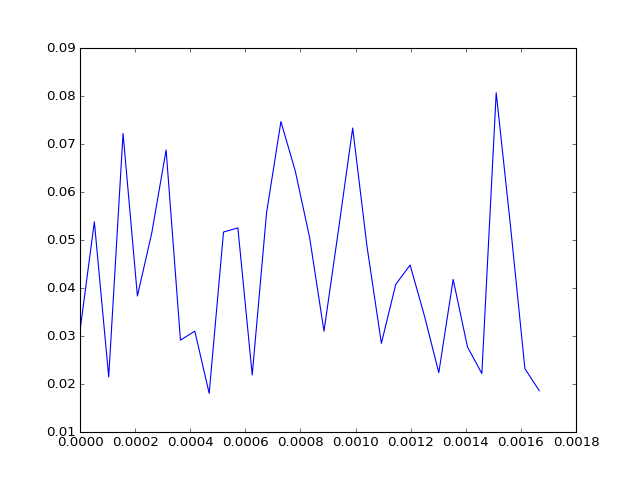

In [48]:
#len(np.linspace(0, 1, num=(len(out)/2 + 1)))
#len(out[0:(len(out)/2 + 1)])
#fs/2*np.linspace(0, 1, num=(len(out)/2 + 1))
#np.absolute(out[0:(len(out)/2 + 1)])
plt.plot(fs/2*np.linspace(0, 1, num=(len(out)/2 + 1)), np.absolute(out[0:(len(out)/2 + 1)]))

In [7]:
rows_list=[]
for i in range(0, len(tick.index), Nticks):
    dict1 = {}
    op = tick.Price.iloc[i]
    hi = tick.Price.iloc[i:i+Nticks].max()
    lo = tick.Price.iloc[i:i+Nticks].min()
    if i+Nticks < len(tick.index):
        cl = tick.loc[i+Nticks-1].Price
    else:
        cl = tick.loc[len(tick.index)-1].Price
    
    vBuy = tick.VolBuy.iloc[i:i+Nticks].sum()
    vSell = tick.VolSell.iloc[i:i+Nticks].sum()
    nBuy = tick.VolBuy.iloc[i:i+Nticks].count()
    nSell = tick.VolSell.iloc[i:i+Nticks].count()
    tClose = tick.DateTime.iloc[i:i+Nticks].max()
    dtime = tick.DateTime.iloc[i:i+Nticks].max()-tick.DateTime.iloc[i:i+Nticks].min()
    dict1.update({'DateTime': tClose, 'open': op, 'high': hi,
                  'low': lo, 'close': cl, 'TickBuy': nBuy,
                  'VolBuy': vBuy, 'TickSell': nSell, 'VolSell': vSell, 'DeltaTime': dtime})
    rows_list.append(dict1)
    
res = pd.DataFrame(rows_list)
res['Dsec'] = res['DeltaTime'].dt.total_seconds()
res['TSpeedBuy'] = res['TickBuy']/res['Dsec']
res['TSpeedSell'] = res['TickSell']/res['Dsec']
res['VSpeedBuy'] = res['VolBuy']/res['Dsec']
res['VSpeedSell'] = res['VolSell']/res['Dsec']
res['OTO'] = ((res['TickBuy']-res['TickSell'])/(res['TickBuy']+res['TickSell'])*0.65
              + (res['VolBuy']-res['VolSell'])/(res['VolBuy']+res['VolSell'])*0.35)*100.0
res['OTON'] = ((res['TickBuy']*res['VolBuy']-res['TickSell']*res['VolSell'])/
               (res['TickBuy']*res['VolBuy']+res['TickSell']*res['VolSell']))*100.0
res['Delta'] = res['VolBuy']-res['VolSell']
res['CumDelta'] = res['Delta'].cumsum()

In [12]:
#res

In [13]:
# res = res.set_index('DateTime')
mids = (res.open + res.close)/2
spans = abs(res.close - res.open)
inc = res.close > res.open
dec = res.open > res.close
#w = 12*60*60
w = 0.5

In [14]:
p = figure(x_range=(0, len(res.index)), plot_width=800, plot_height=600, title='RIM6 CandleStick')
p.y_range=Range1d(start=90500, end=95000)
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha = 0.3
p.segment(res.index.values, res.high, res.index.values, res.low, color='black')
p.rect(res.index[inc], mids[inc], w, spans[inc], fill_color='#6CF350', line_color='green')
p.rect(res.index[dec], mids[dec], w, spans[dec], fill_color='#FF0000', line_color='red')
p.extra_y_ranges = {}
p.extra_y_ranges['TickSpeed'] = Range1d(start=0, end=100)
p.extra_y_ranges['OTO'] = Range1d(start=-60, end=60)
p.extra_y_ranges['OTON'] = Range1d(start=-60, end=60)
p.extra_y_ranges['CumDelta'] = Range1d(start=-3000, end=52000)
#p.line(res.index, res.TSpeedBuy, color='blue', y_range_name='TickSpeed', alpha=0.5)
p.line(res.index, res.TSpeedBuy.rolling(window=4).median(), color='green', y_range_name='TickSpeed', alpha=0.8)
#p.line(res.index, res.TSpeedSell, color='red', y_range_name='TickSpeed', alpha=0.5)
p.line(res.index, res.TSpeedSell.rolling(window=9).median(), color='red', y_range_name='TickSpeed', alpha=0.8)
p.line(res.index, res.OTO.rolling(window=15).mean(), color='brown', y_range_name='OTO', alpha=0.9)
p.line(res.index, res.OTON.rolling(window=15).mean(), color='blue', y_range_name='OTON', alpha=0.9)
p.line(res.index, res.CumDelta, color='black', y_range_name='CumDelta', alpha=0.9)
p.add_layout(LogAxis(y_range_name='TickSpeed'), 'left')
p.add_layout(LinearAxis(y_range_name='OTO'), 'left')
p.add_layout(LinearAxis(y_range_name='OTON'), 'left')
p.add_layout(LinearAxis(y_range_name='CumDelta'), 'left')
#show(p)
l=figure(plot_width=800, plot_height=600, title='FFT')
l.line(resfftfreq, resfft)
m = gridplot([[p, l]])

show(m)

In [ ]:
# plt.plot(fs/2*np.linspace(0, 1, num=(len(out)/2 + 1)), np.absolute(out[1:(len(out)/2 + 1)])
#len(np.absolute(out[1:(len(out)/2 + 1)]))